# First Experiment

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
from pathlib import Path

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## MNIST Dataset

In [3]:
DATA_PATH = "./data"
train_dataset = torchvision.datasets.MNIST(
    root=DATA_PATH,
    train=True,
    transform=transforms.ToTensor(),
    download=True,
)
test_dataset = torchvision.datasets.MNIST(
    root=DATA_PATH,
    train=False,
    transform=transforms.ToTensor(),
    download=True,
)

## Hyperparameters

In [4]:
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.01


## MNIST Dataloaders

In [5]:
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)
test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
)
total_steps = len(train_dataloader)
print(total_steps)

1875


In [6]:
class MNISTModel(nn.Module):
    def __init__(self,input_size:int=28*28):
        super().__init__()
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(input_size,input_size//2)
        self.fc2 = nn.Linear(input_size//2,10)

    def forward(self,x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [7]:
def one_epoch(model:nn.Module,optimizer,criterion):
    running_loss = 0.0
    for images,labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs,labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f"Running Loss: {running_loss/total_steps:.3f}")
    return model

def train_model(model,optimizer,criterion,epochs,save_file,continue_training=False):
    save_file = Path(save_file)
    is_model_available = save_file.is_file()
    if is_model_available:
        model.load_state_dict(torch.load(save_file))
    if is_model_available and not continue_training:
        return model
    for epoch in range(epochs):
        model = one_epoch(model,optimizer,criterion)
        print(f"Epoch {epoch} finished.")
    torch.save(model.state_dict(),save_file)
    return model

In [8]:
model = MNISTModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=LEARNING_RATE,
)
model = train_model(model=model,optimizer=optimizer,criterion=criterion,epochs=20,save_file="./mnist_model.zip")

In [9]:
def accuracy():
    correct = 0
    total = len(test_dataloader.dataset)
    with torch.no_grad():
        for images, labels in test_dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _,predicted = torch.max(outputs,1)
            correct += (predicted==labels).sum().item()
    return correct/total


In [10]:
accuracy()

0.972

## Autoencoder

In [11]:
class AutoEncoder(nn.Module):
    def __init__(self,input:int=28*28):
        super().__init__()
        # self.flatten = nn.Flatten
        self.sigmoid = nn.Sigmoid()
        self.encoder = nn.Sequential(
            nn.Linear(input,128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,36),
            nn.ReLU(),
            nn.Linear(36,18),
            nn.ReLU(),
            nn.Linear(18,9)
        )
        self.decoder = nn.Sequential(
            nn.Linear(9, 18),
            nn.ReLU(),
            nn.Linear(18, 36),
            nn.ReLU(),
            nn.Linear(36, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128,input),
        )
    def forward(self,x):
        # x = self.flatten(x)
        x = self.encoder(x)
        x = self.decoder(x)
        x = self.sigmoid(x)
        return x

In [12]:
model = AutoEncoder().to(device)
loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-1,weight_decay = 1e-8)

In [13]:
def autoencoder_epoch(model,loss,optimizer):
    running_loss = 0.0
    for images,_ in train_dataloader:
        images = images.reshape(-1,28*28)
        
        images = images.to(device)

        outputs = model(images)
        loss = criterion(outputs,images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss+=loss.item()
    print(f"Running Loss: {running_loss/total_steps:.3f}")
    return model


def train_autoencoder(model,loss,optimizer, save_file, epochs=EPOCHS,continue_training=False):
    save_file = Path(save_file)
    if save_file.is_file():
        model.load_state_dict(torch.load(save_file))
    if save_file.is_file() and not continue_training:
        return model
    for epoch in range(epochs):
        model = autoencoder_epoch(model=model,loss=loss,optimizer=optimizer)
        print(f"Finished epoch {epoch+1}.")
    torch.save(model.state_dict(),save_file)
    return model


In [14]:
model = train_autoencoder(model=model,loss=loss,optimizer=optimizer,epochs=50,save_file="./autoencoder.zip")

Running Loss: 639.078
Finished epoch 1.
Running Loss: 639.039
Finished epoch 2.
Running Loss: 639.111
Finished epoch 3.
Running Loss: 639.306
Finished epoch 4.
Running Loss: 639.965
Finished epoch 5.
Running Loss: 639.960
Finished epoch 6.
Running Loss: 639.960
Finished epoch 7.
Running Loss: 640.640
Finished epoch 8.
Running Loss: 641.096
Finished epoch 9.
Running Loss: 641.218
Finished epoch 10.
Running Loss: 641.062
Finished epoch 11.
Running Loss: 640.635
Finished epoch 12.
Running Loss: 640.586
Finished epoch 13.
Running Loss: 640.471
Finished epoch 14.
Running Loss: 640.675
Finished epoch 15.
Running Loss: 640.805
Finished epoch 16.
Running Loss: 640.831
Finished epoch 17.
Running Loss: 641.023
Finished epoch 18.
Running Loss: 641.157
Finished epoch 19.
Running Loss: 640.093
Finished epoch 20.
Running Loss: 640.397
Finished epoch 21.
Running Loss: 641.461
Finished epoch 22.


tensor(1)


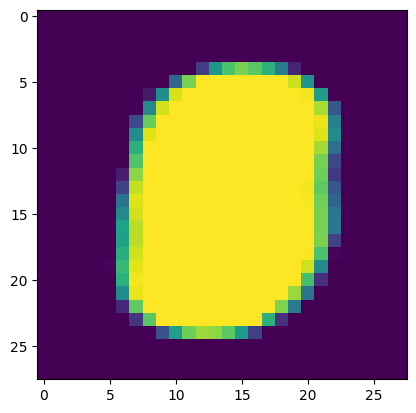

In [ ]:
with torch.no_grad():
    for images,label in test_dataloader:
        print(label[-1])
        images = images.to(device)
        images = images.reshape(-1,28*28)
        images = model(images)
        images = images.reshape(-1,28,28)
        images = images.to("cpu")
        plt.imshow(images[-1])
        break